### load data

In [1]:
# load smiles
with open('./data/demo.smi') as f:
    smiles = [line.strip('\n') for line in f]
len(smiles)

854

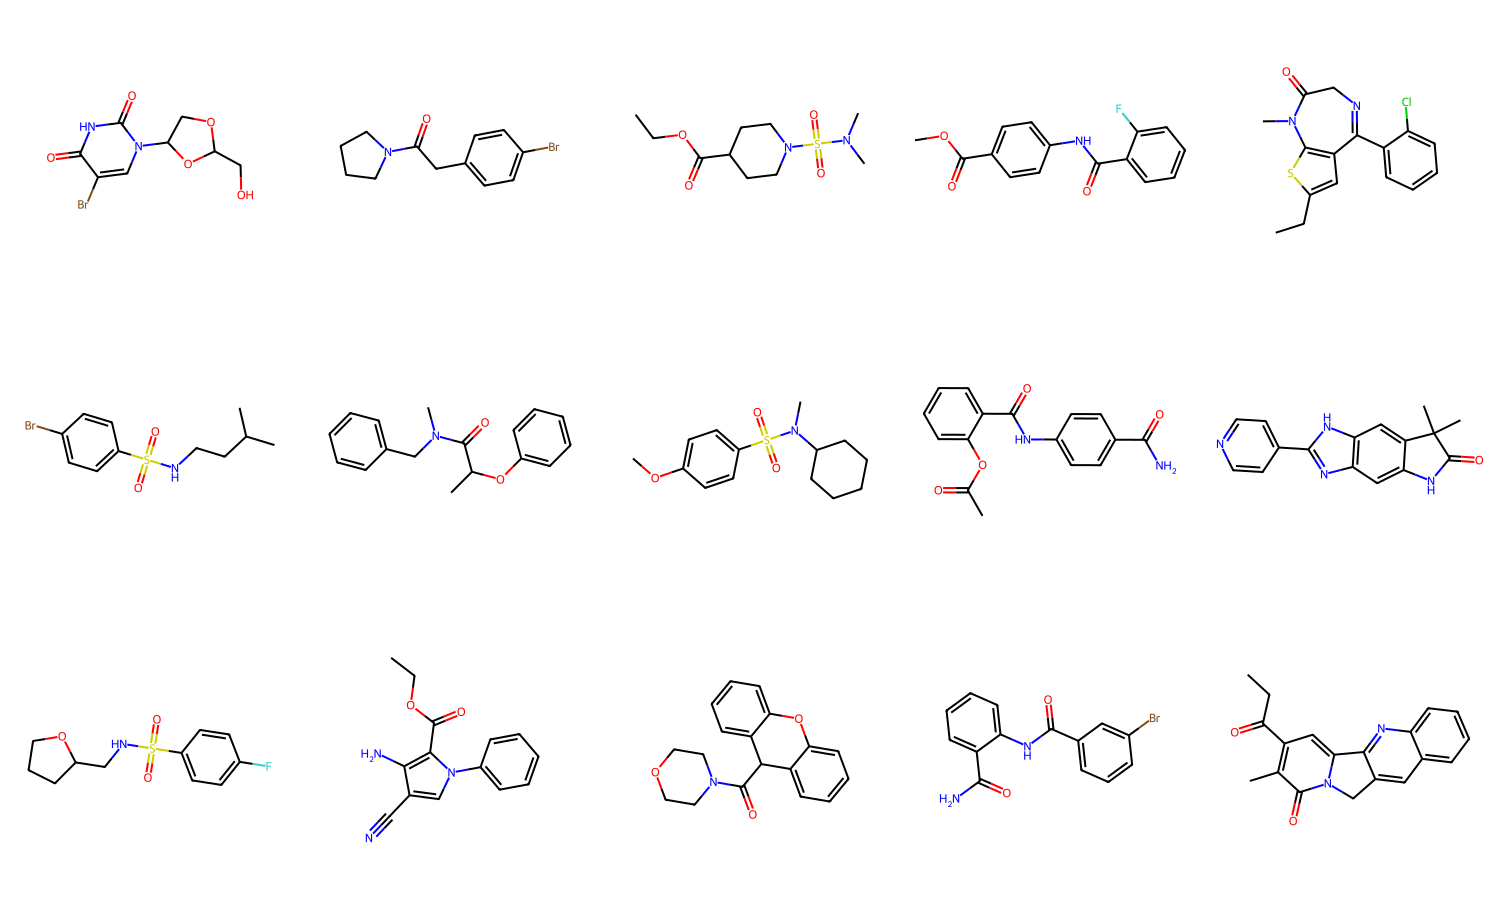

In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
mols = [Chem.MolFromSmiles(s) for s in smiles]
Draw.MolsToGridImage(mols[:15], molsPerRow=5, subImgSize=(300,300))

### preprocess

In [3]:
import torch
from coati.models.encoding.tokenizers.trie_tokenizer import TrieTokenizer
from coati.models.encoding.tokenizers import get_vocab
import numpy as np
from tqdm import tqdm
import pickle
import h5py
f = h5py.File('./data/ecloud.h5', 'r')
ecloud_item = f['eclouds']

tokenizer = TrieTokenizer(n_seq=64, **get_vocab('mar'))
all_data = {
        'smiles':[],
        'eclouds':[],
        'raw_tokens':[],
        'augmented_tokens':[]
}

for i, s in tqdm(enumerate(smiles)):
        s = Chem.MolToSmiles(Chem.MolFromSmiles(s))
        ecloud = [i]
        raw_token = tokenizer.tokenize_text("[SMILES]" + s + "[STOP]", pad=True)
        augmented_token = tokenizer.tokenize_text("[CLIP][UNK][SMILES][SUFFIX][MIDDLE]" + s + "[STOP]", pad=True)
        all_data['smiles'].append(s)
        all_data['eclouds'].append(ecloud_item[i])
        all_data['raw_tokens'].append(raw_token)
        all_data['augmented_tokens'].append(augmented_token)


854it [00:00, 4614.14it/s]


In [4]:
all_data['eclouds']=torch.tensor(all_data['eclouds'])
all_data['raw_tokens']=torch.tensor(all_data['raw_tokens'])
all_data['augmented_tokens']=torch.tensor(all_data['augmented_tokens'])
torch.save(all_data, './data/ecloud_coati_demo.pt')

/tmp/ipykernel_768302/1928315798.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1706665913501/work/torch/csrc/utils/tensor_new.cpp:261.)
  all_data['eclouds']=torch.tensor(all_data['eclouds'])


In [5]:
file=torch.load('./data/ecloud_coati_demo.pt')
file['eclouds'].shape, file['raw_tokens'].shape, file['augmented_tokens'].shape, 

(torch.Size([854, 32, 32, 32]), torch.Size([854, 64]), torch.Size([854, 64]))

In [6]:
len(file['eclouds'])

854

In [10]:
# save as h5 file
with h5py.File('./data/ecloud_coati.h5', 'w') as f:
    eclouds=f.create_dataset("eclouds", (len(smiles),32,32,32), dtype='f')
    raw_tokens=f.create_dataset("raw_tokens", (len(smiles),64), dtype='i')
    augmented_tokens=f.create_dataset("augmented_tokens", (len(smiles),64), dtype='i')
    for i, s in tqdm(enumerate(smiles)):
        s = Chem.MolToSmiles(Chem.MolFromSmiles(s))
        raw_token = tokenizer.tokenize_text("[SMILES]" + s + "[STOP]", pad=True)
        augmented_token = tokenizer.tokenize_text("[CLIP][UNK][SMILES][SUFFIX][MIDDLE]" + s + "[STOP]", pad=True)
        eclouds[i]=ecloud_item[i]
        raw_tokens[i]=raw_token
        augmented_tokens[i]=augmented_token

854it [00:01, 835.07it/s]
